## Описание проекта

## Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Подготовка данных

In [53]:
import time
start = time.time()
import pandas as pd
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from plot_metric.functions import BinaryClassification
from sklearn.utils import shuffle
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('churn.csv')
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 976.6+ KB


In [4]:
df.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

Пропуски обнаружены только в количестве недвижимости

Проверим датафрейм на наличие дубликатов

In [5]:
df.duplicated().sum()

0

Приведем названия признаков к нижнему регистру

In [6]:
df.columns = df.columns.str.lower()

In [7]:
df.columns

Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited'],
      dtype='object')

In [8]:
df.head(5)

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Избавимся от признаков, не несущих никакой смысловой нагрузки, а именно: **rownumber, customerid surname**

In [9]:
df = df.drop(['rownumber', 'customerid', 'surname'], axis=1)

In [10]:
df.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Обработаем пропуски в **tenure**

In [11]:
print('Доля пропусков: {:.2%}'.format(df['tenure'].isna().sum() / len(df)))

Доля пропусков: 9.09%


Почти 10% пропущенных значений, просто удаление данных может показаться аттракционом неслыханной щедрости. Для принятия решения, взглянем на корреляцию данного признака с другими

In [12]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
creditscore,1.00,-0.00,-0.00,0.01,0.01,-0.01,0.03,-0.00,-0.03
age,-0.00,1.00,-0.01,0.03,-0.03,-0.01,0.09,-0.01,0.29
tenure,-0.00,-0.01,1.00,-0.01,0.01,0.03,-0.03,0.01,-0.02
balance,0.01,0.03,-0.01,1.00,-0.30,-0.01,-0.01,0.01,0.12
numofproducts,0.01,-0.03,0.01,-0.30,1.00,0.00,0.01,0.01,-0.05
hascrcard,-0.01,-0.01,0.03,-0.01,0.00,1.00,-0.01,-0.01,-0.01
isactivemember,0.03,0.09,-0.03,-0.01,0.01,-0.01,1.00,-0.01,-0.16
estimatedsalary,-0.00,-0.01,0.01,0.01,0.01,-0.01,-0.01,1.00,0.01
exited,-0.03,0.29,-0.02,0.12,-0.05,-0.01,-0.16,0.01,1.00


Никакой настораживающей взаимосвязи не выявлено. Можно предположить, что пропуски в данном признаке, говорят об отсутствии недвижимости у клиента. Поэтому, на мой взгляд, разумно будет заполнить пропуски нулями.  
Также будет разумно преобразовать тип данного признака **из float в int**.

In [13]:
df.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [14]:
df['tenure'] = df['tenure'].fillna(0).astype(int)
df['tenure'].isna().sum()

0

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creditscore      10000 non-null  int64  
 1   geography        10000 non-null  object 
 2   gender           10000 non-null  object 
 3   age              10000 non-null  int64  
 4   tenure           10000 non-null  int32  
 5   balance          10000 non-null  float64
 6   numofproducts    10000 non-null  int64  
 7   hascrcard        10000 non-null  int64  
 8   isactivemember   10000 non-null  int64  
 9   estimatedsalary  10000 non-null  float64
 10  exited           10000 non-null  int64  
dtypes: float64(2), int32(1), int64(6), object(2)
memory usage: 742.2+ KB


Проведем кодирование с помощью **One-hot-encoding**

In [16]:
df = pd.get_dummies(df, drop_first=True)

Проведем стандартизацию признаком с помощью **StandardScaler**

In [17]:
scaler = StandardScaler()
numeric = ['creditscore', 'age', 'balance', 'estimatedsalary']
scaler.fit(df[numeric])
df[numeric] = scaler.transform(df[numeric])

In [18]:
df.head(5)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,-0.326221,0.293517,2,-1.225848,1,1,1,0.021886,1,0,0,0
1,-0.440036,0.198164,1,0.117350,1,0,1,0.216534,0,0,1,0
2,-1.536794,0.293517,8,1.333053,3,1,0,0.240687,1,0,0,0
3,0.501521,0.007457,1,-1.225848,2,0,0,-0.108918,0,0,0,0
4,2.063884,0.388871,2,0.785728,1,1,1,-0.365276,0,0,1,0


Разобьем полученный датасет на 3 выборки: обучающую, валидационную и тестовую (60-20-20). Выделим целевой признак

In [19]:
features = df.drop('exited', axis=1)
target = df['exited']

features_train, features_valid_test, target_train, target_valid_test = train_test_split(features, target, 
                                                                                        test_size=0.4, random_state=12345)
print(features_train.shape)
print(features_valid_test.shape)
print(target_train.shape)
print(target_valid_test.shape)

(6000, 11)
(4000, 11)
(6000,)
(4000,)


In [20]:
features_valid, features_test, target_valid, target_test = train_test_split(features_valid_test, target_valid_test, 
                                                                            test_size=0.5, random_state=12345)
print(features_valid.shape)
print(features_test.shape)
print(target_valid.shape)
print(target_test.shape)

(2000, 11)
(2000, 11)
(2000,)
(2000,)


### Вывод

Предобработка данных завершена:

- Наименования столбцов приведены к нижнему регистру
- Пропущенные значения в признаке tenure заменены на 0, тип данных изменен на int
- Удалены излишние признаки
- Определены признаки и целевой признак
- Категориальные признаки обработаны техникой прямого кодирования
- Количественные признаки приведены к единому масштабу
- Итоговый датасет поделен на обучающую, валидационную и тестовую выборки

# 2. Исследование задачи

Взглянем на баланс классов

In [21]:
df['exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: exited, dtype: float64

Классы несбалансированны

Рассмотрим стандартные модели, для каждой рассчитаем **accuracy, recall, precision, f1, roc_auc, а также матрицу ошибок**

Модель **RandomForestClassifier** со стандартными параметрами

In [22]:
model_forest = RandomForestClassifier(random_state=12345)
model_forest.fit(features_train, target_train)
predicted_valid = model_forest.predict(features_valid)
print('accuracy:', accuracy_score(target_valid, predicted_valid))
print('precision:', precision_score(target_valid, predicted_valid))
print('recall:', recall_score(target_valid, predicted_valid))
print('f1:', f1_score(target_valid, predicted_valid))
probabilities_valid_forest = model_forest.predict_proba(features_valid)
probabilities_one_valid_forest = probabilities_valid_forest[:, 1]
print('roc_auc:', roc_auc_score(target_valid, probabilities_one_valid_forest))
confusion_matrix(target_valid, predicted_valid)

accuracy: 0.8585
precision: 0.7626459143968871
recall: 0.4688995215311005
f1: 0.5807407407407408
roc_auc: 0.8417483773794905


array([[1521,   61],
       [ 222,  196]], dtype=int64)

In [23]:
best_model_forest = None
best_depth_forest = 0
best_n_est = 0
best_acc_forest = 0
best_prec_forest = 0
best_rec_forest = 0
best_f1_forest = 0
best_roc_auc_forest = 0
for depth in range(1, 20, 1):
    for n in range(1, 51, 5):
        model_forest = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=n)
        model_forest.fit(features_train, target_train)
        predicted_valid_forest = model_forest.predict(features_valid)
        print("max_depth =", depth,":")
        print("estimators =", n, ":")
        print('accuracy:', accuracy_score(target_valid, predicted_valid_forest))
        print('recall:', recall_score(target_valid, predicted_valid_forest))
        print('precision:', precision_score(target_valid, predicted_valid_forest))
        result_forest = f1_score(target_valid, predicted_valid_forest)
        print('f1 score:', result_forest)
        probabilities_valid_forest = model_forest.predict_proba(features_valid)
        probabilities_one_valid_forest = probabilities_valid_forest[:, 1]
        print('roc_auc:', roc_auc_score(target_valid, probabilities_one_valid_forest))
        print()
        if result_forest > best_f1_forest:
            best_model_forest = model_forest
            best_depth_forest = depth
            best_n_est = n
            best_acc_forest = accuracy_score(target_valid, predicted_valid_forest)
            best_prec_forest = precision_score(target_valid, predicted_valid_forest)
            best_rec_forest = recall_score(target_valid, predicted_valid_forest)
            best_f1_forest = result_forest
            probabilities_valid_forest = model_forest.predict_proba(features_valid)
            probabilities_one_valid_forest = probabilities_valid_forest[:, 1]
            best_roc_auc_forest = roc_auc_score(target_valid, probabilities_one_valid_forest)
print()
print('Лучшие параметры модели:')
print('Depth:', best_depth_forest)
print('Estimators:', best_n_est)
print("Accuracy:", best_acc_forest)
print("Recall:", best_rec_forest)
print("Precision:", best_prec_forest)
print("F1:", best_f1_forest)
print("ROC_AUC:", best_roc_auc_forest)

max_depth = 1 :
estimators = 1 :
accuracy: 0.8155
recall: 0.145933014354067
precision: 0.8356164383561644
f1 score: 0.2484725050916497
roc_auc: 0.5691738396675518

max_depth = 1 :
estimators = 6 :
accuracy: 0.791
recall: 0.0
precision: 0.0
f1 score: 0.0
roc_auc: 0.7756776293106056

max_depth = 1 :
estimators = 11 :
accuracy: 0.791
recall: 0.0
precision: 0.0
f1 score: 0.0
roc_auc: 0.741959484390784

max_depth = 1 :
estimators = 16 :
accuracy: 0.791
recall: 0.0
precision: 0.0
f1 score: 0.0
roc_auc: 0.784472746629244

max_depth = 1 :
estimators = 21 :
accuracy: 0.791
recall: 0.0
precision: 0.0
f1 score: 0.0
roc_auc: 0.7850050508411011

max_depth = 1 :
estimators = 26 :
accuracy: 0.791
recall: 0.0
precision: 0.0
f1 score: 0.0
roc_auc: 0.789971963295205

max_depth = 1 :
estimators = 31 :
accuracy: 0.791
recall: 0.0
precision: 0.0
f1 score: 0.0
roc_auc: 0.7943113011813524

max_depth = 1 :
estimators = 36 :
accuracy: 0.791
recall: 0.0
precision: 0.0
f1 score: 0.0
roc_auc: 0.7969002353026574



max_depth = 6 :
estimators = 16 :
accuracy: 0.86
recall: 0.4138755980861244
precision: 0.8317307692307693
f1 score: 0.5527156549520766
roc_auc: 0.8442367483471349

max_depth = 6 :
estimators = 21 :
accuracy: 0.8615
recall: 0.39952153110047844
precision: 0.8652849740932642
f1 score: 0.5466448445171849
roc_auc: 0.8476339682674103

max_depth = 6 :
estimators = 26 :
accuracy: 0.8615
recall: 0.4090909090909091
precision: 0.8507462686567164
f1 score: 0.5525040387722132
roc_auc: 0.8474086463140958

max_depth = 6 :
estimators = 31 :
accuracy: 0.8585
recall: 0.39473684210526316
precision: 0.8461538461538461
f1 score: 0.5383360522022839
roc_auc: 0.8475432345949346

max_depth = 6 :
estimators = 36 :
accuracy: 0.8565
recall: 0.37559808612440193
precision: 0.8579234972677595
f1 score: 0.5224625623960067
roc_auc: 0.8493775670068171

max_depth = 6 :
estimators = 41 :
accuracy: 0.8585
recall: 0.38995215311004783
precision: 0.8534031413612565
f1 score: 0.5353037766830869
roc_auc: 0.8502637325413291

ma

roc_auc: 0.8395715253540126

max_depth = 11 :
estimators = 16 :
accuracy: 0.8635
recall: 0.4688995215311005
precision: 0.7935222672064778
f1 score: 0.5894736842105264
roc_auc: 0.8411570962805243

max_depth = 11 :
estimators = 21 :
accuracy: 0.863
recall: 0.46172248803827753
precision: 0.7975206611570248
f1 score: 0.5848484848484847
roc_auc: 0.8440560371161209

max_depth = 11 :
estimators = 26 :
accuracy: 0.864
recall: 0.46172248803827753
precision: 0.8041666666666667
f1 score: 0.5866261398176292
roc_auc: 0.8421279465760136

max_depth = 11 :
estimators = 31 :
accuracy: 0.861
recall: 0.45454545454545453
precision: 0.7916666666666666
f1 score: 0.5775075987841946
roc_auc: 0.8461224965067538

max_depth = 11 :
estimators = 36 :
accuracy: 0.8605
recall: 0.4473684210526316
precision: 0.7957446808510639
f1 score: 0.5727411944869832
roc_auc: 0.8475016483283834

max_depth = 11 :
estimators = 41 :
accuracy: 0.8605
recall: 0.4473684210526316
precision: 0.7957446808510639
f1 score: 0.572741194486983

max_depth = 16 :
estimators = 16 :
accuracy: 0.8555
recall: 0.4688995215311005
precision: 0.7452471482889734
f1 score: 0.5756240822320118
roc_auc: 0.8291961299064233

max_depth = 16 :
estimators = 21 :
accuracy: 0.8525
recall: 0.4784688995215311
precision: 0.7220216606498195
f1 score: 0.5755395683453238
roc_auc: 0.8315673032137867

max_depth = 16 :
estimators = 26 :
accuracy: 0.8575
recall: 0.47607655502392343
precision: 0.7509433962264151
f1 score: 0.5827232796486091
roc_auc: 0.8349312541208209

max_depth = 16 :
estimators = 31 :
accuracy: 0.8595
recall: 0.4784688995215311
precision: 0.7604562737642585
f1 score: 0.5873715124816447
roc_auc: 0.8357954923511515

max_depth = 16 :
estimators = 36 :
accuracy: 0.8615
recall: 0.47607655502392343
precision: 0.77431906614786
f1 score: 0.5896296296296296
roc_auc: 0.8356336839685699

max_depth = 16 :
estimators = 41 :
accuracy: 0.8605
recall: 0.48325358851674644
precision: 0.7622641509433963
f1 score: 0.5915080527086384
roc_auc: 0.837703167814951

В результате длительного перебора, получаем значение F1-меры, заявленного, как целевое у всего исследования, **0.5963431786216596**, посмотрим, насколько удастся ее увеличить в следующем разделе

Модель **DecisionTreeClassifier** со стандартными параметрами

In [24]:
model_tree = DecisionTreeClassifier(random_state=12345)
model_tree.fit(features_train, target_train)
predicted_valid = model_tree.predict(features_valid)

print('accuracy:', accuracy_score(target_valid, predicted_valid))
print('recall:', recall_score(target_valid, predicted_valid))
print('precision:', precision_score(target_valid, predicted_valid))
print('f1:', f1_score(target_valid, predicted_valid))
probabilities_valid_tree = model_tree.predict_proba(features_valid)
probabilities_one_valid_tree = probabilities_valid_tree[:, 1]
print('roc_auc:', roc_auc_score(target_valid, probabilities_one_valid_tree))
confusion_matrix(target_valid, predicted_valid)

accuracy: 0.7855
recall: 0.47368421052631576
precision: 0.4864864864864865
f1: 0.4799999999999999
roc_auc: 0.6707864794730187


array([[1373,  209],
       [ 220,  198]], dtype=int64)

Проитерируем гиперпараметр максимальной глубины от 1 до 20, найдем наиболее высокий результат модели

In [25]:
best_model_tree = None
best_depth_tree = 0
best_acc_tree = 0
best_prec_tree = 0
best_rec_tree = 0
best_f1_tree = 0
best_roc_auc_tree = 0
for depth in range(1, 20): 
    model_tree = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model_tree.fit(features_train, target_train)
    predictions_valid = model_tree.predict(features_valid)
    print("max_depth =", depth, ":")
    print('accuracy:', accuracy_score(target_valid, predictions_valid))
    print('recall:', recall_score(target_valid, predictions_valid))
    print('precision:', precision_score(target_valid, predictions_valid))
    result_tree = f1_score(target_valid, predictions_valid)
    print('f1:', result_tree)
    probabilities_valid_tree = model_tree.predict_proba(features_valid)
    probabilities_one_valid_tree = probabilities_valid_tree[:, 1]
    print('roc_auc:', roc_auc_score(target_valid, probabilities_one_valid_tree))
    print()
    if result_tree > best_f1_tree:
        best_model_tree = model_tree
        best_depth_tree = depth
        best_acc_tree = accuracy_score(target_valid, predictions_valid)
        best_rec_tree = recall_score(target_valid, predictions_valid)
        best_prec_tree = precision_score(target_valid, predictions_valid)
        best_f1_tree = f1_score(target_valid, predictions_valid)
        probabilities_valid_tree = model_tree.predict_proba(features_valid)
        probabilities_one_valid_tree = probabilities_valid_tree[:, 1]
        best_roc_auc_tree = roc_auc_score(target_valid, probabilities_one_valid_tree)
print()
print('Лучшие параметры модели:')
print('Depth:', best_depth_tree)
print("Accuracy:", best_acc_tree)
print("Recall:", best_rec_tree)
print("Precision:", best_prec_tree)
print("F1:", best_f1_tree)
print("ROC_AUC:", best_roc_auc_tree)

max_depth = 1 :
accuracy: 0.791
recall: 0.0
precision: 0.0
f1: 0.0
roc_auc: 0.6925565119556736

max_depth = 2 :
accuracy: 0.824
recall: 0.45933014354066987
precision: 0.6037735849056604
f1: 0.5217391304347825
roc_auc: 0.7501814673449512

max_depth = 3 :
accuracy: 0.838
recall: 0.284688995215311
precision: 0.8263888888888888
f1: 0.4234875444839857
roc_auc: 0.7973440741838507

max_depth = 4 :
accuracy: 0.852
recall: 0.43779904306220097
precision: 0.75
f1: 0.5528700906344411
roc_auc: 0.813428129858032

max_depth = 5 :
accuracy: 0.853
recall: 0.4138755980861244
precision: 0.7792792792792793
f1: 0.5406249999999999
roc_auc: 0.8221680508592478

max_depth = 6 :
accuracy: 0.858
recall: 0.44976076555023925
precision: 0.7768595041322314
f1: 0.5696969696969697
roc_auc: 0.8164631712023421

max_depth = 7 :
accuracy: 0.8505
recall: 0.40669856459330145
precision: 0.7692307692307693
f1: 0.5320813771517998
roc_auc: 0.8152322177124227

max_depth = 8 :
accuracy: 0.8505
recall: 0.42822966507177035
precisio

F1-мера достигла аж ~ 0.58, чего от дерева решений, признаться не совсем не ожидал, совсем чуток остался до заветной цели

Модель **LogisticRegression** со стандартными параметрами

In [26]:
model_log = LogisticRegression(random_state=12345, solver='liblinear')
model_log.fit(features_train, target_train)
predicted_valid = model_log.predict(features_valid)
print('accuracy:', accuracy_score(target_valid, predicted_valid))
print('precision:', precision_score(target_valid, predicted_valid))
print('recall:', recall_score(target_valid, predicted_valid))
print('f1 score:', f1_score(target_valid, predicted_valid))
probabilities_valid_log = model_log.predict_proba(features_valid)
probabilities_one_valid_log = probabilities_valid_log[:, 1]
print('roc auc:', roc_auc_score(target_valid, probabilities_one_valid_log))
confusion_matrix(target_valid, predicted_valid)

accuracy: 0.8025
precision: 0.5657142857142857
recall: 0.23684210526315788
f1 score: 0.33389544688026984
roc auc: 0.7585713075931986


array([[1506,   76],
       [ 319,   99]], dtype=int64)

Построим кривую ошибок

AUC-ROC DecisionTreeClassifier 0.6813078049105064
AUC-ROC RandomForestClassifier 0.8391269303588819
AUC-ROC LogisticRegression 0.7585713075931986


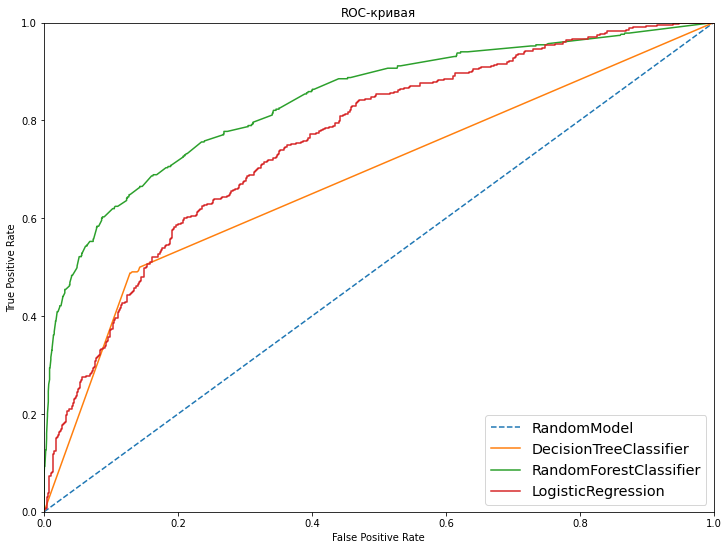

In [27]:
plt.figure(figsize=[12,9])
plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_tree)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid_tree)
print('AUC-ROC DecisionTreeClassifier',auc_roc)
plt.plot(fpr, tpr, label='DecisionTreeClassifier')

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_forest)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid_forest)
print('AUC-ROC RandomForestClassifier',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier')

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_log)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid_log)
print('AUC-ROC LogisticRegression',auc_roc)
plt.plot(fpr, tpr, label='LogisticRegression')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

### Вывод

Наиболее высоких показателей удалось добиться моделью случайного леса, со следующими параметрами:

- Depth: 9
- Accuracy: 0.85
- Recall: 0.49282296650717705
- Precision: 0.7006802721088435
- F1: 0.5786516853932585
- ROC_AUC: 0.7899719632952051

# 3. Борьба с дисбалансом

Для начала борьбы, будем балансировать вес

Начинаем со стандартной модели случайного леса

In [28]:
model_forest_balanced = RandomForestClassifier(random_state=12345, class_weight='balanced')
model_forest_balanced.fit(features_train, target_train)
predictions_valid = model_forest_balanced.predict(features_valid)
probabilities_valid = model_forest_balanced.predict_proba(features_valid)
print('accuracy_score:',accuracy_score(target_valid, predictions_valid))
print('f1:',f1_score(target_valid, predictions_valid))
print('AUC-ROC:',roc_auc_score(target_valid, probabilities_valid[:,1]))

accuracy_score: 0.855
f1: 0.5592705167173253
AUC-ROC: 0.8382793266351719


Определим модель с лучшими параметрами

In [29]:
best_model_forest = None
best_depth_forest = 0
best_n_est = 0
best_acc_forest = 0
best_prec_forest = 0
best_rec_forest = 0
best_f1_forest = 0
best_roc_auc_forest = 0
for depth in range(1, 20, 1):
    for n in range(1, 51, 5):
        model_forest = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=n, class_weight='balanced')
        model_forest.fit(features_train, target_train)
        predicted_valid_forest = model_forest.predict(features_valid)
        result_forest = f1_score(target_valid, predicted_valid_forest)
        probabilities_valid_forest = model_forest.predict_proba(features_valid)
        probabilities_one_valid_forest = probabilities_valid_forest[:, 1]
        if result_forest > best_f1_forest:
            best_model_forest = model_forest
            best_depth_forest = depth
            best_n_est = n
            best_acc_forest = accuracy_score(target_valid, predicted_valid_forest)
            best_prec_forest = precision_score(target_valid, predicted_valid_forest)
            best_rec_forest = recall_score(target_valid, predicted_valid_forest)
            best_f1_forest = result_forest
            probabilities_valid_forest = model_forest.predict_proba(features_valid)
            probabilities_one_valid_forest = probabilities_valid_forest[:, 1]
            best_roc_auc_forest = roc_auc_score(target_valid, probabilities_one_valid_forest)
print('Лучшие параметры модели:')
print('Depth:', best_depth_forest)
print('Estimators:', best_n_est)
print("Accuracy:", best_acc_forest)
print("Recall:", best_rec_forest)
print("Precision:", best_prec_forest)
print("F1:", best_f1_forest)
print("ROC_AUC:", best_roc_auc_forest)

Лучшие параметры модели:
Depth: 8
Estimators: 41
Accuracy: 0.8265
Recall: 0.7033492822966507
Precision: 0.5686653771760155
F1: 0.6288770053475936
ROC_AUC: 0.8534878023699636


F1-мера превысила целевую отметку и составила: **0.6288770053475936**

А теперь взглянем на результаты модели DecisionTreeClassifier

In [30]:
model_tree_balanced = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
model_tree_balanced.fit(features_train, target_train)
predictions_valid = model_tree_balanced.predict(features_valid)
probabilities_valid = model_tree_balanced.predict_proba(features_valid)
print('accuracy_score:',accuracy_score(target_valid, predictions_valid))
print('F1:',f1_score(target_valid, predictions_valid))
print('ROC_AUC:',roc_auc_score(target_valid, probabilities_valid[:,1]))

accuracy_score: 0.779
F1: 0.4556650246305418
ROC_AUC: 0.6552362402385691


Определим модель с лучшими параметрами

In [31]:
best_model_tree = None
best_depth_tree = 0
best_acc_tree = 0
best_prec_tree = 0
best_rec_tree = 0
best_f1_tree = 0
best_roc_auc_tree = 0
for depth in range(1, 20): 
    model_tree = DecisionTreeClassifier(max_depth=depth, random_state=12345, class_weight='balanced')
    model_tree.fit(features_train, target_train)
    predictions_valid = model_tree.predict(features_valid)
    result_tree = f1_score(target_valid, predictions_valid)
    probabilities_valid_tree = model_tree.predict_proba(features_valid)
    probabilities_one_valid_tree = probabilities_valid_tree[:, 1]
    if result_tree > best_f1_tree:
        best_model_tree = model_tree
        best_depth_tree = depth
        best_acc_tree = accuracy_score(target_valid, predictions_valid)
        best_rec_tree = recall_score(target_valid, predictions_valid)
        best_prec_tree = precision_score(target_valid, predictions_valid)
        best_f1_tree = f1_score(target_valid, predictions_valid)
        probabilities_valid_tree = model_tree.predict_proba(features_valid)
        probabilities_one_valid_tree = probabilities_valid_tree[:, 1]
        best_roc_auc_tree = roc_auc_score(target_valid, probabilities_one_valid_tree)
print('Лучшие параметры модели:')
print('Depth:', best_depth_tree)
print("Accuracy:", best_acc_tree)
print("Recall:", best_rec_tree)
print("Precision:", best_prec_tree)
print("F1:", best_f1_tree)
print("ROC_AUC:", best_roc_auc_tree)

Лучшие параметры модели:
Depth: 5
Accuracy: 0.8105
Recall: 0.6698564593301436
Precision: 0.5374280230326296
F1: 0.5963791267305644
ROC_AUC: 0.8310244134068074


Наблюдаем также увеличение F1-меры до целевого показателя, но не такое резкое, как у модели случайного леса

Применим технику увеличения выборки путем повторения несколько раз положительных объектов: **upsampling**

In [32]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [33]:
print('Размеры таблицы features_upsampled:', features_upsampled.shape)
print('Размеры таблицы target_upsampled:',target_upsampled.shape)
print()
print(target_upsampled.value_counts(normalize=True))

Размеры таблицы features_upsampled: (9588, 11)
Размеры таблицы target_upsampled: (9588,)

0    0.501043
1    0.498957
Name: exited, dtype: float64


Поглядим на результаты модели **случайного леса на увеличенной выборке**

In [34]:
model_forest_balanced2 = RandomForestClassifier(random_state=12345, class_weight='balanced')
model_forest_balanced2.fit(features_upsampled, target_upsampled)
predictions_valid = model_forest_balanced2.predict(features_valid)
probabilities_valid = model_forest_balanced2.predict_proba(features_valid)
print('accuracy_score:',accuracy_score(target_valid, predictions_valid))
print('F1:',f1_score(target_valid, predictions_valid))
print('ROC-AUC:',roc_auc_score(target_valid, probabilities_valid[:,1]))

accuracy_score: 0.8505
F1: 0.6050198150594451
ROC-AUC: 0.8373251108463031


Определим лучшие параметры модели

In [35]:
best_model_forest = None
best_depth_forest = 0
best_n_est = 0
best_acc_forest = 0
best_prec_forest = 0
best_rec_forest = 0
best_f1_forest = 0
best_roc_auc_forest = 0
for depth in range(1, 20, 1):
    for n in range(1, 51, 5):
        model_forest = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=n, class_weight='balanced')
        model_forest.fit(features_upsampled, target_upsampled)
        predicted_valid_forest = model_forest.predict(features_valid)
        result_forest = f1_score(target_valid, predicted_valid_forest)
        probabilities_valid_forest = model_forest.predict_proba(features_valid)
        probabilities_one_valid_forest = probabilities_valid_forest[:, 1]
        if result_forest > best_f1_forest:
            best_model_forest = model_forest
            best_depth_forest = depth
            best_n_est = n
            best_acc_forest = accuracy_score(target_valid, predicted_valid_forest)
            best_prec_forest = precision_score(target_valid, predicted_valid_forest)
            best_rec_forest = recall_score(target_valid, predicted_valid_forest)
            best_f1_forest = result_forest
            probabilities_valid_forest = model_forest.predict_proba(features_valid)
            probabilities_one_valid_forest = probabilities_valid_forest[:, 1]
            best_roc_auc_forest = roc_auc_score(target_valid, probabilities_one_valid_forest)
print('Лучшие параметры модели:')
print('Depth:', best_depth_forest)
print('Estimators:', best_n_est)
print("Accuracy:", best_acc_forest)
print("Recall:", best_rec_forest)
print("Precision:", best_prec_forest)
print("F1:", best_f1_forest)
print("ROC_AUC:", best_roc_auc_forest)

Лучшие параметры модели:
Depth: 13
Estimators: 41
Accuracy: 0.845
Recall: 0.6124401913875598
Precision: 0.6336633663366337
F1: 0.6228710462287105
ROC_AUC: 0.8434496337384088


Значение F1-меры снизилось на 0 целых, несколько десятитысячных

Посмотрим на результаты **DecisionTreeClassifier**

In [36]:
model_tree_balanced2 = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
model_tree_balanced2.fit(features_upsampled, target_upsampled)
predictions_valid = model_tree_balanced2.predict(features_valid)
probabilities_valid = model_tree_balanced2.predict_proba(features_valid)
print('accuracy_score:',accuracy_score(target_valid, predictions_valid))
print('F1:',f1_score(target_valid, predictions_valid))
print('ROC_AUC:',roc_auc_score(target_valid, probabilities_valid[:,1]))

accuracy_score: 0.7875
F1: 0.47724477244772445
ROC_AUC: 0.6685302354841246


In [37]:
best_model_tree = None
best_depth_tree = 0
best_acc_tree = 0
best_prec_tree = 0
best_rec_tree = 0
best_f1_tree = 0
best_roc_auc_tree = 0
for depth in range(1, 20): 
    model_tree = DecisionTreeClassifier(max_depth=depth, random_state=12345, class_weight='balanced')
    model_tree.fit(features_upsampled, target_upsampled)
    predictions_valid = model_tree.predict(features_valid)
    result_tree = f1_score(target_valid, predictions_valid)
    probabilities_valid_tree = model_tree.predict_proba(features_valid)
    probabilities_one_valid_tree = probabilities_valid_tree[:, 1]
    if result_tree > best_f1_tree:
        best_model_tree = model_tree
        best_depth_tree = depth
        best_acc_tree = accuracy_score(target_valid, predictions_valid)
        best_rec_tree = recall_score(target_valid, predictions_valid)
        best_prec_tree = precision_score(target_valid, predictions_valid)
        best_f1_tree = f1_score(target_valid, predictions_valid)
        probabilities_valid_tree = model_tree.predict_proba(features_valid)
        probabilities_one_valid_tree = probabilities_valid_tree[:, 1]
        best_roc_auc_tree = roc_auc_score(target_valid, probabilities_one_valid_tree)
print('Лучшие параметры модели:')
print('Depth:', best_depth_tree)
print("Accuracy:", best_acc_tree)
print("Recall:", best_rec_tree)
print("Precision:", best_prec_tree)
print("F1:", best_f1_tree)
print("ROC_AUC:", best_roc_auc_tree)

Лучшие параметры модели:
Depth: 5
Accuracy: 0.8105
Recall: 0.6698564593301436
Precision: 0.5374280230326296
F1: 0.5963791267305644
ROC_AUC: 0.8310244134068074


Значение F1-меры увеличить не удалось

Применим технику изменения выборки путем уменьшения количества отрицательных объектов: **downsampling**

In [38]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

In [39]:
print('Размеры таблицы features_downsampled:', features_downsampled.shape)
print('Размеры таблицы target_downsampled:',target_downsampled.shape)
print()
print(target_downsampled.value_counts(normalize=True))

Размеры таблицы features_downsampled: (2397, 11)
Размеры таблицы target_downsampled: (2397,)

0    0.501043
1    0.498957
Name: exited, dtype: float64


Посмотрим на результаты модели случайного леса на уменьшенной выборке

In [40]:
model_forest_balanced3 = RandomForestClassifier(random_state=12345, class_weight='balanced')
model_forest_balanced3.fit(features_downsampled, target_downsampled)
predictions_valid = model_forest_balanced3.predict(features_valid)
probabilities_valid = model_forest_balanced3.predict_proba(features_valid)
print('accuracy_score:',accuracy_score(target_valid, predictions_valid))
print('F1:',f1_score(target_valid, predictions_valid))
print('ROC-AUC:',roc_auc_score(target_valid, probabilities_valid[:,1]))

accuracy_score: 0.782
F1: 0.5894538606403014
ROC-AUC: 0.8436621017547892


Определим лучшие параметры модели

In [41]:
best_model_forest = None
best_depth_forest = 0
best_n_est = 0
best_acc_forest = 0
best_prec_forest = 0
best_rec_forest = 0
best_f1_forest = 0
best_roc_auc_forest = 0
for depth in range(1, 20, 1):
    for n in range(1, 51, 5):
        model_forest = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=n, class_weight='balanced')
        model_forest.fit(features_downsampled, target_downsampled)
        predicted_valid_forest = model_forest.predict(features_valid)
        result_forest = f1_score(target_valid, predicted_valid_forest)
        probabilities_valid_forest = model_forest.predict_proba(features_valid)
        probabilities_one_valid_forest = probabilities_valid_forest[:, 1]
        if result_forest > best_f1_forest:
            best_model_forest = model_forest
            best_depth_forest = depth
            best_n_est = n
            best_acc_forest = accuracy_score(target_valid, predicted_valid_forest)
            best_prec_forest = precision_score(target_valid, predicted_valid_forest)
            best_rec_forest = recall_score(target_valid, predicted_valid_forest)
            best_f1_forest = result_forest
            probabilities_valid_forest = model_forest.predict_proba(features_valid)
            probabilities_one_valid_forest = probabilities_valid_forest[:, 1]
            best_roc_auc_forest = roc_auc_score(target_valid, probabilities_one_valid_forest)
print('Лучшие параметры модели:')
print('Depth:', best_depth_forest)
print('Estimators:', best_n_est)
print("Accuracy:", best_acc_forest)
print("Recall:", best_rec_forest)
print("Precision:", best_prec_forest)
print("F1:", best_f1_forest)
print("ROC_AUC:", best_roc_auc_forest)

Лучшие параметры модели:
Depth: 11
Estimators: 31
Accuracy: 0.7905
Recall: 0.7583732057416268
Precision: 0.49921259842519683
F1: 0.6020892687559355
ROC_AUC: 0.8478759247273453


Значение F1-меры не принесло положительных результатов

Теперь посмотрим на модель решающего дерева

In [42]:
model_tree_balanced3 = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
model_tree_balanced3.fit(features_downsampled, target_downsampled)
predictions_valid = model_tree_balanced3.predict(features_valid)
probabilities_valid = model_tree_balanced3.predict_proba(features_valid)
print('accuracy_score:',accuracy_score(target_valid, predictions_valid))
print('F1:',f1_score(target_valid, predictions_valid))
print('ROC_AUC:',roc_auc_score(target_valid, probabilities_valid[:,1]))

accuracy_score: 0.698
F1: 0.48726655348047543
ROC_AUC: 0.6938071244079628


In [43]:
best_model_tree = None
best_depth_tree = 0
best_acc_tree = 0
best_prec_tree = 0
best_rec_tree = 0
best_f1_tree = 0
best_roc_auc_tree = 0
for depth in range(1, 20): 
    model_tree = DecisionTreeClassifier(max_depth=depth, random_state=12345, class_weight='balanced')
    model_tree.fit(features_downsampled, target_downsampled)
    predictions_valid = model_tree.predict(features_valid)
    result_tree = f1_score(target_valid, predictions_valid)
    probabilities_valid_tree = model_tree.predict_proba(features_valid)
    probabilities_one_valid_tree = probabilities_valid_tree[:, 1]
    if result_tree > best_f1_tree:
        best_model_tree = model_tree
        best_depth_tree = depth
        best_acc_tree = accuracy_score(target_valid, predictions_valid)
        best_rec_tree = recall_score(target_valid, predictions_valid)
        best_prec_tree = precision_score(target_valid, predictions_valid)
        best_f1_tree = f1_score(target_valid, predictions_valid)
        probabilities_valid_tree = model_tree.predict_proba(features_valid)
        probabilities_one_valid_tree = probabilities_valid_tree[:, 1]
        best_roc_auc_tree = roc_auc_score(target_valid, probabilities_one_valid_tree)
print('Лучшие параметры модели:')
print('Depth:', best_depth_tree)
print("Accuracy:", best_acc_tree)
print("Recall:", best_rec_tree)
print("Precision:", best_prec_tree)
print("F1:", best_f1_tree)
print("ROC_AUC:", best_roc_auc_tree)

Лучшие параметры модели:
Depth: 5
Accuracy: 0.799
Recall: 0.7009569377990431
Precision: 0.5140350877192983
F1: 0.5931174089068827
ROC_AUC: 0.82291433531536


Значение F1-меры также снизилось, по сравнению с обычным балансированием

### Вывод

В данном разделе исследования мы сделали следущие шаги:

- выполнили балансировку данных;
- обыграли модели техниками upsampling и downsampling для поиска максимального результата;

Максимальное значение найденной F1-меры показала модель случайного леса и составила **0.6288770053475936**


# 4. Тестирование модели

Опробуем нашу лучшую модель на тестовой выборке

In [51]:
model = RandomForestClassifier(n_estimators = 41, max_depth=8, random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_test)
probabilities_valid = model.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]

accuracy_valid = accuracy_score(predicted_valid, target_test)
print('Accuracy:', accuracy_valid)
print('F1:', f1_score(target_test, predicted_valid))

Accuracy: 0.8175
F1: 0.6096256684491979


Построим ROC-кривую нашей лучшей модели на тестовой выборке

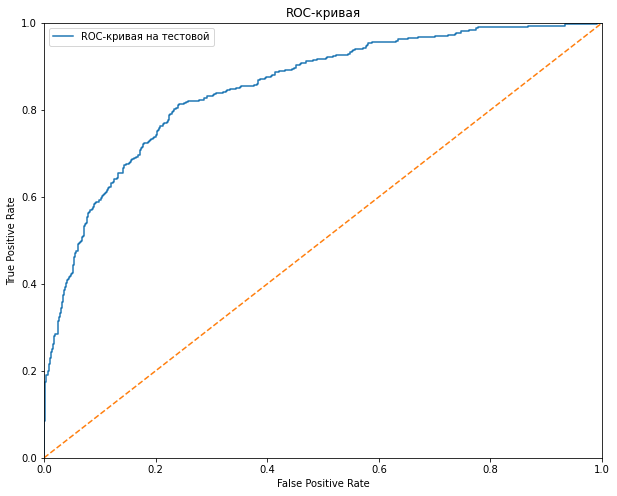

In [52]:
fpr_test, tpr_test, thresholds = roc_curve(target_test, probabilities_one_valid)
plt.figure(figsize=(10, 8))
plt.plot(fpr_test, tpr_test, label='ROC-кривая на тестовой')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend()
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Построим график важности признаков

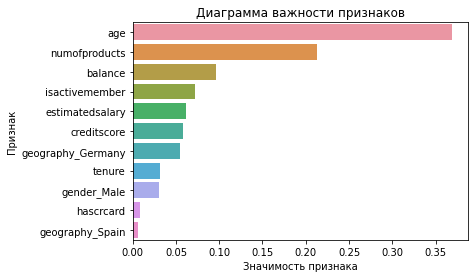

In [57]:
feature_imp = pd.Series(model.feature_importances_, index=features_test.columns).sort_values(ascending=False)
ax = sns.barplot(x=feature_imp, y=feature_imp.index)
_ = ax.set(xlabel='Значимость признака', ylabel='Признак')
_ = ax.set_title('Диаграмма важности признаков')

### Вывод

На тестовой выборке удалось достичь F1-меры не менее 0.59, что соответствует поставленной задаче